# Cluster Analysis Course Notebook

### Importing Data files

In [1]:
#Import Product DataSet here
import os, types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
client_d260161e2b05413ca3f1e0e322b55432 = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='CgYwxWN2JusesRgMarUbQm6649W23w8bA9G5U8gP5Qcc',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3.private.eu.cloud-object-storage.appdomain.cloud')

body = client_d260161e2b05413ca3f1e0e322b55432.get_object(Bucket='project1-donotdelete-pr-x8xe7cylx5imxg',Key='Product Data Set - Student 2 of 3.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

product_data = pd.read_csv(body,sep='|')
product_data.head()



,PRODUCT CODE,PRODUCT CATEGORY,UNIT LIST PRICE
0,30001,HEALTH & BEAUTY,$7.45
1,30002,HEALTH & BEAUTY,$5.35
2,30003,HEALTH & BEAUTY,$5.49
3,30004,HEALTH & BEAUTY,$6.46
4,30005,HEALTH & BEAUTY,$7.33


In [2]:
#Import Transaction DataSet here
body = client_d260161e2b05413ca3f1e0e322b55432.get_object(Bucket='project1-donotdelete-pr-x8xe7cylx5imxg',Key='Transaction Data Set - Student 3 of 3.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

transactions_data = pd.read_csv(body,sep='|')
transactions_data.head()

,CUSTOMER NUM,PRODUCT NUM,QUANTITY PURCHASED,DISCOUNT TAKEN,TRANSACTION DATE,STOCKOUT
0,10114,30011,4,0.0,1/2/2015,0
1,10217,30016,3,0.0,1/2/2015,0
2,10224,30013,4,0.0,1/2/2015,0
3,10103,30012,3,0.2,1/2/2015,0
4,10037,30010,8,0.0,1/2/2015,0


In [3]:
#Import Customer Dataset Here
body = client_d260161e2b05413ca3f1e0e322b55432.get_object(Bucket='project1-donotdelete-pr-x8xe7cylx5imxg',Key='Customer Data Set - Student 1 of 3.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

customer_data=pd.read_csv(body)
customer_data.head()


,CUSTOMERID,GENDER,AGE,INCOME,EXPERIENCE SCORE,LOYALTY GROUP,ENROLLMENT DATE,HOUSEHOLD SIZE,MARITAL STATUS
0,10001,0,64,"$133,498",5,enrolled,06-03-2013,4,Single
1,10002,0,42,"$94,475",9,notenrolled,NaN,6,Married
2,10003,0,40,"$88,610",9,enrolled,02-09-2010,5,Married
3,10004,0,38,"$84,313",8,enrolled,06-04-2015,1,Single
4,10005,0,30,"$51,498",3,notenrolled,NaN,1,Single


### Changing data types

In [4]:
customer_data['INCOME']=customer_data['INCOME'].map(lambda x : x.replace('$',''))

In [5]:
customer_data['INCOME']=customer_data['INCOME'].map(lambda x : int(x.replace(',','')))

### Creating Customer View

In [6]:
trans_products=transactions_data.merge(product_data,how='inner', left_on='PRODUCT NUM', right_on='PRODUCT CODE')

In [7]:
trans_products['UNIT LIST PRICE']=trans_products['UNIT LIST PRICE'].map(lambda x : float(x.replace('$','')))

In [8]:
trans_products['Total_Price']=trans_products['QUANTITY PURCHASED'] * trans_products['UNIT LIST PRICE'] * (1- trans_products['DISCOUNT TAKEN'])

In [9]:
customer_prod_categ=trans_products.groupby(['CUSTOMER NUM','PRODUCT CATEGORY']).agg({'Total_Price':'sum'})

In [10]:
customer_prod_categ=customer_prod_categ.reset_index()

In [11]:
customer_pivot=customer_prod_categ.pivot(index='CUSTOMER NUM',columns='PRODUCT CATEGORY',values='Total_Price')

In [12]:
trans_total_spend=trans_products.groupby('CUSTOMER NUM').agg({'Total_Price':'sum'}).\
rename(columns={'Total_Price':'TOTAL SPENT'})

In [13]:
customer_KPIs=customer_pivot.merge(trans_total_spend,how='inner',left_index=True, right_index=True )

In [14]:
customer_KPIs=customer_KPIs.fillna(0)


In [15]:
customer_all_view=customer_data.merge(customer_KPIs,how='inner', left_on='CUSTOMERID', right_index=True)

In [16]:
customer_all_view.head()

,CUSTOMERID,GENDER,AGE,INCOME,EXPERIENCE SCORE,LOYALTY GROUP,ENROLLMENT DATE,HOUSEHOLD SIZE,MARITAL STATUS,APPAREL,ELECTRONICS,FOOD,HEALTH & BEAUTY,TOTAL SPENT
0,10001,0,64,133498,5,enrolled,06-03-2013,4,Single,4022.430,1601.315,68.688,1134.337,6826.770
1,10002,0,42,94475,9,notenrolled,NaN,6,Married,2312.509,2473.163,276.779,0.000,5062.451
2,10003,0,40,88610,9,enrolled,02-09-2010,5,Married,2887.382,5414.418,260.640,0.000,8562.440
3,10004,0,38,84313,8,enrolled,06-04-2015,1,Single,3637.213,1840.211,45.270,0.000,5522.694
4,10005,0,30,51498,3,notenrolled,NaN,1,Single,213.512,0.000,0.000,0.000,213.512


# Clustering  

In [17]:
#Begin Writing your code here
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering

In [18]:
cluster_input=customer_all_view[['INCOME','TOTAL SPENT']]
cluster_input.head(5)

,INCOME,TOTAL SPENT
0,133498,6826.770
1,94475,5062.451
2,88610,8562.440
3,84313,5522.694
4,51498,213.512


In [19]:
Kmeans_model=KMeans(n_clusters=4)

In [20]:
Kmeans_model

KMeans(n_clusters=4)

In [21]:
cluster_output = Kmeans_model.fit_predict(cluster_input)

In [22]:
cluster_output

array([1, 0, 0, 0, 2, 1, 0, 3, 3, 0, 2, 3, 0, 0, 2, 0, 0, 3, 1, 0, 3, 3,
       3, 2, 3, 3, 0, 2, 2, 1, 0, 2, 2, 0, 2, 2, 2, 3, 3, 2, 2, 0, 0, 0,
       1, 2, 2, 0, 1, 2, 3, 2, 2, 2, 3, 2, 3, 3, 3, 2, 0, 3, 1, 3, 1, 0,
       0, 3, 2, 0, 0, 2, 0, 0, 1, 2, 0, 2, 0, 1, 0, 3, 1, 3, 2, 3, 1, 2,
       0, 2, 3, 1, 3, 3, 3, 0, 3, 2, 1, 3, 2, 2, 2, 2, 0, 3, 3, 2, 0, 2,
       2, 2, 0, 2, 3, 2, 1, 1, 0, 0, 2, 3, 3, 2, 0, 0, 3, 0, 2, 1, 0, 0,
       2, 0, 1, 3, 1, 1, 3, 0, 0, 2, 2, 2, 0, 3, 3, 2, 3, 0, 0, 3, 3, 3,
       0, 3, 2, 2, 3, 2, 1, 2, 1, 3, 2, 0, 2, 1, 0, 2, 1, 2, 3, 3, 1, 2,
       1, 1, 3, 2, 1, 2, 0, 2, 3, 1, 3, 3, 2, 1, 2, 3, 3, 1, 3, 1, 3, 1,
       3, 0, 3, 2, 1, 1, 3, 2, 0, 1, 1, 1, 1, 2, 3, 0, 1, 3, 2, 3, 0, 2,
       0, 2, 3, 2, 2, 2, 3, 2, 2, 0, 3, 0, 3, 0, 0, 2, 3, 1, 2, 2, 2, 0,
       0, 0, 0, 2, 3, 3, 1, 2, 0, 3, 2, 3, 2, 0, 2, 1, 3, 3, 2, 1, 2, 0,
       0, 1, 3, 0, 0, 3, 1, 2, 1, 2, 2, 2, 1, 0, 3, 3, 3, 0, 0, 0, 1, 0,
       3, 0, 3, 1, 1, 2, 2, 1, 2, 2, 2, 2, 0, 0, 2,

In [23]:
type(cluster_output)

numpy.ndarray

In [24]:
product_data.head()

,PRODUCT CODE,PRODUCT CATEGORY,UNIT LIST PRICE
0,30001,HEALTH & BEAUTY,$7.45
1,30002,HEALTH & BEAUTY,$5.35
2,30003,HEALTH & BEAUTY,$5.49
3,30004,HEALTH & BEAUTY,$6.46
4,30005,HEALTH & BEAUTY,$7.33


In [25]:
product_data.head().values

array([[30001, 'HEALTH & BEAUTY', ' $7.45 '],
       [30002, 'HEALTH & BEAUTY', ' $5.35 '],
       [30003, 'HEALTH & BEAUTY', ' $5.49 '],
       [30004, 'HEALTH & BEAUTY', ' $6.46 '],
       [30005, 'HEALTH & BEAUTY', ' $7.33 ']], dtype=object)

In [26]:
product_data.head().values[1,2]

' $5.35 '

In [27]:
product_data.head().values[1,:]

array([30002, 'HEALTH & BEAUTY', ' $5.35 '], dtype=object)

In [28]:
product_data.head().values[:,2]

array([' $7.45 ', ' $5.35 ', ' $5.49 ', ' $6.46 ', ' $7.33 '],
      dtype=object)

In [29]:
cluster_output_pd=pd.DataFrame(cluster_output,columns=['segment'])

In [30]:
cluster_output_pd.head()

,segment
0,1
1,0
2,0
3,0
4,2


In [31]:
segment_DF=pd.concat([cluster_input,cluster_output_pd],axis=1)

In [32]:
segment_DF.head()

,INCOME,TOTAL SPENT,segment
0,133498,6826.770,1
1,94475,5062.451,0
2,88610,8562.440,0
3,84313,5522.694,0
4,51498,213.512,2


In [33]:
Kmeans_model.cluster_centers_

array([[ 78928.39130435,   5409.89650725],
       [138629.34482759,   6996.87572414],
       [ 40121.17333333,   2444.07018667],
       [111401.552     ,   7782.934592  ]])

In [34]:
segment_DF[segment_DF.segment==0].head()

,INCOME,TOTAL SPENT,segment
1,94475,5062.451,0
2,88610,8562.440,0
3,84313,5522.694,0
6,65002,5224.616,0
9,76994,6620.147,0


In [35]:
import matplotlib.pyplot as plt

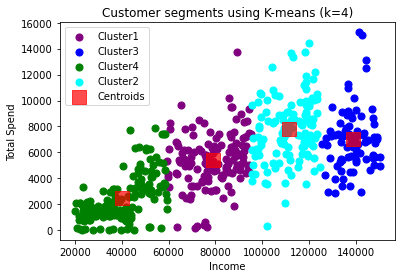

In [36]:
plt.scatter(segment_DF[segment_DF.segment==0]['INCOME'],segment_DF[segment_DF.segment==0]['TOTAL SPENT'],s=50, c='purple',label='Cluster1')

plt.scatter(segment_DF[segment_DF.segment==1]['INCOME'],segment_DF[segment_DF.segment==1]['TOTAL SPENT'],s=50, c='blue',label='Cluster3')

plt.scatter(segment_DF[segment_DF.segment==2]['INCOME'],segment_DF[segment_DF.segment==2]['TOTAL SPENT'],s=50, c='green',label='Cluster4')

plt.scatter(segment_DF[segment_DF.segment==3]['INCOME'],segment_DF[segment_DF.segment==3]['TOTAL SPENT'],s=50, c='cyan',label='Cluster2')

plt.scatter(Kmeans_model.cluster_centers_[:,0], Kmeans_model.cluster_centers_[:,1],s=200,marker='s', c='red', alpha=0.7, label='Centroids')

plt.title('Customer segments using K-means (k=4)')

plt.xlabel('Income')

plt.ylabel('Total Spend')

plt.legend()

plt.show()

In [37]:
customer_demographics=pd.concat([customer_all_view,cluster_output_pd],axis=1)


customer_demographics.head()

,CUSTOMERID,GENDER,AGE,INCOME,EXPERIENCE SCORE,LOYALTY GROUP,ENROLLMENT DATE,HOUSEHOLD SIZE,MARITAL STATUS,APPAREL,ELECTRONICS,FOOD,HEALTH & BEAUTY,TOTAL SPENT,segment
0,10001,0,64,133498,5,enrolled,06-03-2013,4,Single,4022.430,1601.315,68.688,1134.337,6826.770,1
1,10002,0,42,94475,9,notenrolled,NaN,6,Married,2312.509,2473.163,276.779,0.000,5062.451,0
2,10003,0,40,88610,9,enrolled,02-09-2010,5,Married,2887.382,5414.418,260.640,0.000,8562.440,0
3,10004,0,38,84313,8,enrolled,06-04-2015,1,Single,3637.213,1840.211,45.270,0.000,5522.694,0
4,10005,0,30,51498,3,notenrolled,NaN,1,Single,213.512,0.000,0.000,0.000,213.512,2


In [38]:
customer_demographics.groupby('segment').agg({'AGE':'mean','HOUSEHOLD SIZE':'median'})

,AGE,HOUSEHOLD SIZE
segment,,
0,36.352518,3
1,73.609195,2
2,24.932886,2
3,47.888000,3


In [39]:
def percent_loyalty(series):
    percent=100 * series.value_counts()['enrolled'] /series.count()
    return percent

In [40]:

customer_demographics.groupby('segment').agg({'AGE':'mean','HOUSEHOLD SIZE':'median','LOYALTY GROUP': percent_loyalty})

,AGE,HOUSEHOLD SIZE,LOYALTY GROUP
segment,,,
0,36.352518,3,34.532374
1,73.609195,2,65.517241
2,24.932886,2,50.335570
3,47.888000,3,67.200000
